In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [ ]:
# Divide up into cars and notcars
images = glob.glob('*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

In [16]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

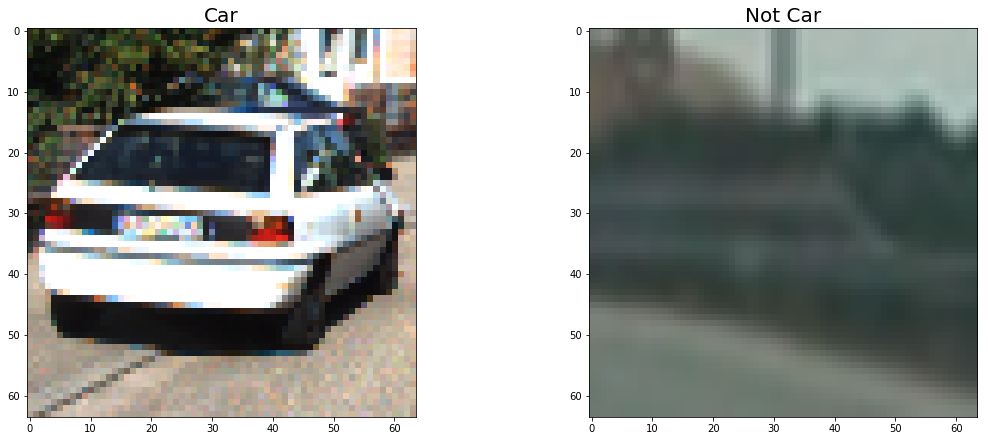

In [17]:
image1=mpimg.imread('./vehicles/KITTI_extracted/17.png')
image2=mpimg.imread('./non-vehicles/GTI/image17.png')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
f.tight_layout()
ax1.imshow(image1)
ax1.set_title("Car", fontsize=20)
ax2.imshow(image2)
ax2.set_title("Not Car", fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

converted_car_image = cv2.cvtColor(image1, cv2.COLOR_RGB2HLS)
car_ch1 = converted_car_image[:,:,0]
car_ch2 = converted_car_image[:,:,1]
car_ch3 = converted_car_image[:,:,2]

converted_notcar_image = cv2.cvtColor(image2, cv2.COLOR_RGB2HLS)
notcar_ch1 = converted_notcar_image[:,:,0]
notcar_ch2 = converted_notcar_image[:,:,1]
notcar_ch3 = converted_notcar_image[:,:,2]

car_ch1_features = cv2.resize(car_ch1, spatial_size)
car_ch2_features = cv2.resize(car_ch2, spatial_size)
car_ch3_features = cv2.resize(car_ch3, spatial_size)
notcar_ch1_features = cv2.resize(notcar_ch1, spatial_size)
notcar_ch2_features = cv2.resize(notcar_ch2, spatial_size)
notcar_ch3_features = cv2.resize(notcar_ch3, spatial_size)

car_hog_feature, car_hog_image = get_hog_features(car_ch1, orient, pix_per_cell, cell_per_block,vis=True, feature_vec=True)

notcar_hog_feature, notcar_hog_image = get_hog_features(notcar_ch1,orient, pix_per_cell, cell_per_block,vis=True, feature_vec=True)